In [ ]:
import sys
sys.path.append('C:\\Users\\henri\\source\\repos\\mozubi_tools\\_Analysis\\Correlation')
sys.path.append('C:\\Users\\henri\\source\\repos\\mozubi_tools\\')
import corr_functions as cfnc
import _Data.PredictionDataBase.DBFunctions as db
import tensorflow as tf
import corr_functions as cf
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [293]:
df = db.GetDAPrices().join(db.GetIDPrices()).join(db.GetLoad()).join(db.GetGeneration()[['Solar','Wind_Onshore']]).loc['2017':'2018'].drop(columns=['DAVolume','IDVolume'])
df = cf.AppendTimeIndexes(df).drop(columns=['Hour','DayOfYear'])
df = df.interpolate(method='pchip')

dfTest = df.loc['2017']
df = df.loc['2018']
df.head()

DAPrice  IDPrice  LoadVolume  Solar  Wind_Onshore  \
TimeStamp                                                                
2018-01-01 00:00:00    -5.27     9.98     49041.0    0.0       29643.0   
2018-01-01 00:15:00    -5.27     6.55     48289.0    0.0       29813.0   
2018-01-01 00:30:00    -5.27   -10.67     47859.0    0.0       30304.0   
2018-01-01 00:45:00    -5.27   -28.40     47568.0    0.0       30662.0   
2018-01-01 01:00:00   -29.99     6.64     47645.0    0.0       30793.0   

                     QuarterHour  WeekDay  DayOfYear  
TimeStamp                                             
2018-01-01 00:00:00          0.0        0          1  
2018-01-01 00:15:00          1.0        0          1  
2018-01-01 00:30:00          2.0        0          1  
2018-01-01 00:45:00          3.0        0          1  
2018-01-01 01:00:00          4.0        0          1

In [ ]:
def getTrainTestSets(df_X,df_y, train_test_split=0.9):
    y = df_y.values
    X = df_X.values
    split = int(len(X)*train_test_split)
    X_train, X_test = X[0:split], X[split:]
    y_train, y_test = y[0:split], y[split:]
    return X_train,X_test,y_train,y_test

In [ ]:
Y_train = df.pop('IDPrice')
X_train = cf.NormalizeDf(df)
Y_test = dfTest.pop('IDPrice')
X_test = cf.NormalizeDf(dfTest)

In [ ]:
x_train = X_train.values.reshape(365,96,7)
y_train = Y_train.values.reshape(365,96,1)
x_test = X_test.values.reshape(365,96,7)
y_test = Y_test.values.reshape(365,96,1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

# !rm -rf "logs\\"
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [287]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(96,input_shape=(96,7)))
    model.add(tf.keras.layers.Dense(96*7,activation='sigmoid'))
    # Shape => [batch, out_steps, features]
    model.add(tf.keras.layers.Reshape([96, 7]))
    model.add(tf.keras.layers.Dense(96))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.5)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [288]:
# best result val_mae = ~12
EPOCHS = 200
model = build_model()
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    validation_split = 0.20, verbose=1,shuffle=False,batch_size=96*3,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=15),tensorboard_callback])

e: 446.9455 - val_loss: 648.6928 - val_mae: 20.9514 - val_mse: 648.6928
Epoch 18/200
2/2 [==============================] - 0s 33ms/step - loss: 425.5395 - mae: 15.8241 - mse: 425.5395 - val_loss: 608.5734 - val_mae: 20.1037 - val_mse: 608.5734
Epoch 19/200
2/2 [==============================] - 0s 32ms/step - loss: 409.1596 - mae: 15.3805 - mse: 409.1596 - val_loss: 574.2842 - val_mae: 19.3485 - val_mse: 574.2842
Epoch 20/200
2/2 [==============================] - 0s 32ms/step - loss: 396.9947 - mae: 15.0262 - mse: 396.9947 - val_loss: 545.0200 - val_mae: 18.6857 - val_mse: 545.0200
Epoch 21/200
2/2 [==============================] - 0s 30ms/step - loss: 388.3495 - mae: 14.7523 - mse: 388.3496 - val_loss: 520.0837 - val_mae: 18.1081 - val_mse: 520.0837
Epoch 22/200
2/2 [==============================] - 0s 31ms/step - loss: 382.6293 - mae: 14.5562 - mse: 382.6293 - val_loss: 498.8705 - val_mae: 17.6029 - val_mse: 498.8706
Epoch 23/200
2/2 [==============================] - 0s 31ms/ste

In [289]:
y_pred = model.predict(x_test)

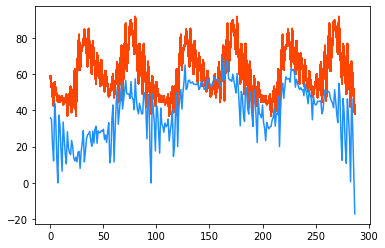

In [292]:
plt.plot(yp[0:96*3],color='OrangeRed') # predicted
plt.plot(yt[0:96*3],color='DodgerBlue') # test

In [248]:
# Correct reshaping needed

# start = 0
# num = 96*7*52
# yp = y_pred.reshape(-1,y_pred.shape[2])
# yt = y_test.reshape(-1,y_test.shape[2])
# plt.plot(yp[start:num+start],label='prediction',color='dodgerblue')
# plt.plot(yt[start:num+start],label='actual',color='orangered')
# plt.legend()
# print('RMSE: '+ str(mean_squared_error(yt, yp,squared=False)))
# print('MAE: '+ str(mean_absolute_error(yt,yp)))
# print('R²: '+ str(r2_score(yt,yp)))

ValueError: y_true and y_pred have different number of output (1!=96)

In [ ]:
y_pred.shape